# Flag hits likely due to abundance differences

In [96]:
# Imports
import polars as pl
from tqdm import tqdm
import plotnine as plotnine

In [85]:
# Paths
metrics_dir = "/dgx1nas1/storage/data/jess/varchamp/sc_data/classification_results/B7B8_1percent_updatedmeta"
prof_dir = "/dgx1nas1/storage/data/jess/repos/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles"
metrics_df = pl.read_csv(f"{metrics_dir}/metrics.csv")
metrics_wtvar = pl.read_csv(f"{metrics_dir}/metrics_summary.csv")
thresh = 3  # previously 10
min_class_num = 2

In [ ]:
# Filter profiles to only include cells from classifiers that passed filters
# Examine median intensity differences

In [86]:
local_wtvar = metrics_wtvar.filter(pl.col("Classifier_type") == "localization")

# Alleles must be mislocalized in both batches
local_wtvar = local_wtvar.with_columns(
    pl.when(pl.col("AUROC_mean") > pl.col("AUROC_thresh"))
    .then(1)
    .otherwise(0)
    .alias("Mislocalized")
).unique()

local_wtvar = local_wtvar.pivot(
    index=["allele_0", "Allele_set"],
    columns="Batch",
    values="Mislocalized",
).with_columns(
    ((pl.col("batch7") == 1) & (pl.col("batch8") == 1)).alias(
        "Mislocalized_both_batches"
    )
)

misloc_alleles = (
    local_wtvar
    # .filter(pl.col("Mislocalized_both_batches"))
    .select("allele_0")
    .to_series()
    .to_list()
)

misloc_wt = (
    local_wtvar
    # .filter(pl.col("Mislocalized_both_batches"))
    .with_columns(pl.col("allele_0").str.replace("_.*", "").alias("wt"))
    .select("wt")
    .to_series()
    .unique()
    .to_list()
)

all_alleles = misloc_alleles + misloc_wt

In [88]:
# Get individual classifiers
ind_class = metrics_df.filter(
    (~pl.col("Metadata_Control"))
    & (pl.col("Training_imbalance") < thresh)
    & (
        pl.col("allele_0").is_in(misloc_alleles)
        & (pl.col("Full_Classifier_ID").str.contains("true"))
    )
)

In [89]:
# Get meta features
b7_alleles = (
    pl.scan_parquet(
        f"{prof_dir}/2024_01_23_Batch_7/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells_metacorr.parquet"
    )
    .filter(pl.col("Metadata_gene_allele").is_in(all_alleles))
    .select([
        "Metadata_CellID",
        "Metadata_gene_allele",
        "Metadata_Well",
        "Metadata_Plate",
    ])
)
b8_alleles = (
    pl.scan_parquet(
        f"{prof_dir}/2024_02_06_Batch_8/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells_metacorr.parquet"
    )
    .filter(pl.col("Metadata_gene_allele").is_in(all_alleles))
    .select([
        "Metadata_CellID",
        "Metadata_gene_allele",
        "Metadata_Well",
        "Metadata_Plate",
    ])
)

cell_alleles = pl.concat([b7_alleles.collect(), b8_alleles.collect()])

In [90]:
b7_prof = pl.scan_parquet(
    f"{prof_dir}/2024_01_23_Batch_7/profiles.parquet"
).with_columns(
    pl.concat_str(
        [
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_ImageNumber",
            "Metadata_ObjectNumber",
        ],
        separator="_",
    ).alias("Metadata_CellID")
)
b8_prof = pl.scan_parquet(
    f"{prof_dir}/2024_02_06_Batch_8/profiles.parquet"
).with_columns(
    pl.concat_str(
        [
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_ImageNumber",
            "Metadata_ObjectNumber",
        ],
        separator="_",
    ).alias("Metadata_CellID")
)

gfp_int = [i for i in b7_prof.columns if "Cells_Intensity" in i]
gfp_int = ["Metadata_CellID"] + [i for i in gfp_int if "GFP" in i]

profiles = pl.concat([
    b7_prof.select(gfp_int).collect(),
    b8_prof.select(gfp_int).collect(),
])

# This method of joining ensures that only cells past filters are included in the abundance analysis
profiles = cell_alleles.join(profiles, on="Metadata_CellID", how="left")

In [91]:
import statsmodels.formula.api as smf


def lmm(fix_var: str, rand_var: str, reference: str, var: str, dat):
    # perform stat test
    model = smf.mixedlm(
        f"{fix_var} ~ C(Metadata_gene_allele, Treatment(reference='{reference}'))",
        data=dat,
        groups=dat[rand_var],
    )
    result = model.fit()

    # format results
    summary_df = pl.DataFrame(result.summary().tables[1][1:2])
    summary_df = summary_df.with_columns([
        pl.col(column).cast(pl.Float64).alias(column) for column in summary_df.columns
    ])

    summary_df = summary_df.with_columns(
        pl.lit(reference).alias("Gene"), pl.lit(var).alias("Variant")
    )

    return summary_df

In [92]:
abun_stats = []
for allele in tqdm(misloc_alleles):
    temp_class = ind_class.filter(pl.col("allele_0") == allele)
    temp_prof = profiles.filter(
        (pl.col("Metadata_Plate").is_in(temp_class.select("Plate").to_series()))
        & (
            pl.col("Metadata_Well").is_in(temp_class.select("well_1"))
            | pl.col("Metadata_Well").is_in(temp_class.select("well_0"))
        )
    )
    abun_stats.append(
        lmm(
            "Cells_Intensity_MedianIntensity_GFP",
            "Metadata_Plate",
            allele.split("_")[0],
            allele,
            temp_prof.to_pandas(),
        )
    )

abun_stats = pl.concat(abun_stats, how="vertical")
abun_stats = abun_stats.rename({"z": "U2OS_Z"})

  2%|▏         | 9/471 [00:01<01:35,  4.85it/s]/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization fa

In [100]:
# Compare to yeast data
yeast_abun = (
    pl.read_csv("../data/abundance_ppi_his3_edgotyping.tsv", separator="\t")
    .filter(pl.col("node_type") == "allele")
    .with_columns(
        pl.concat_str(["symbol", "aa_change"], separator="_").alias("Variant")
    )
    .select(["Variant", "z_abundance_change"])
    .filter(pl.col("z_abundance_change").is_not_null())
    .with_columns(pl.col("z_abundance_change").cast(pl.Float64))
    .rename({"z_abundance_change": "Yeast_Z"})
)
abun_both = abun_stats.join(yeast_abun, on="Variant", how="left").filter(
    pl.col("Yeast_Z").is_not_null()
)

/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 174 rows containing missing values.


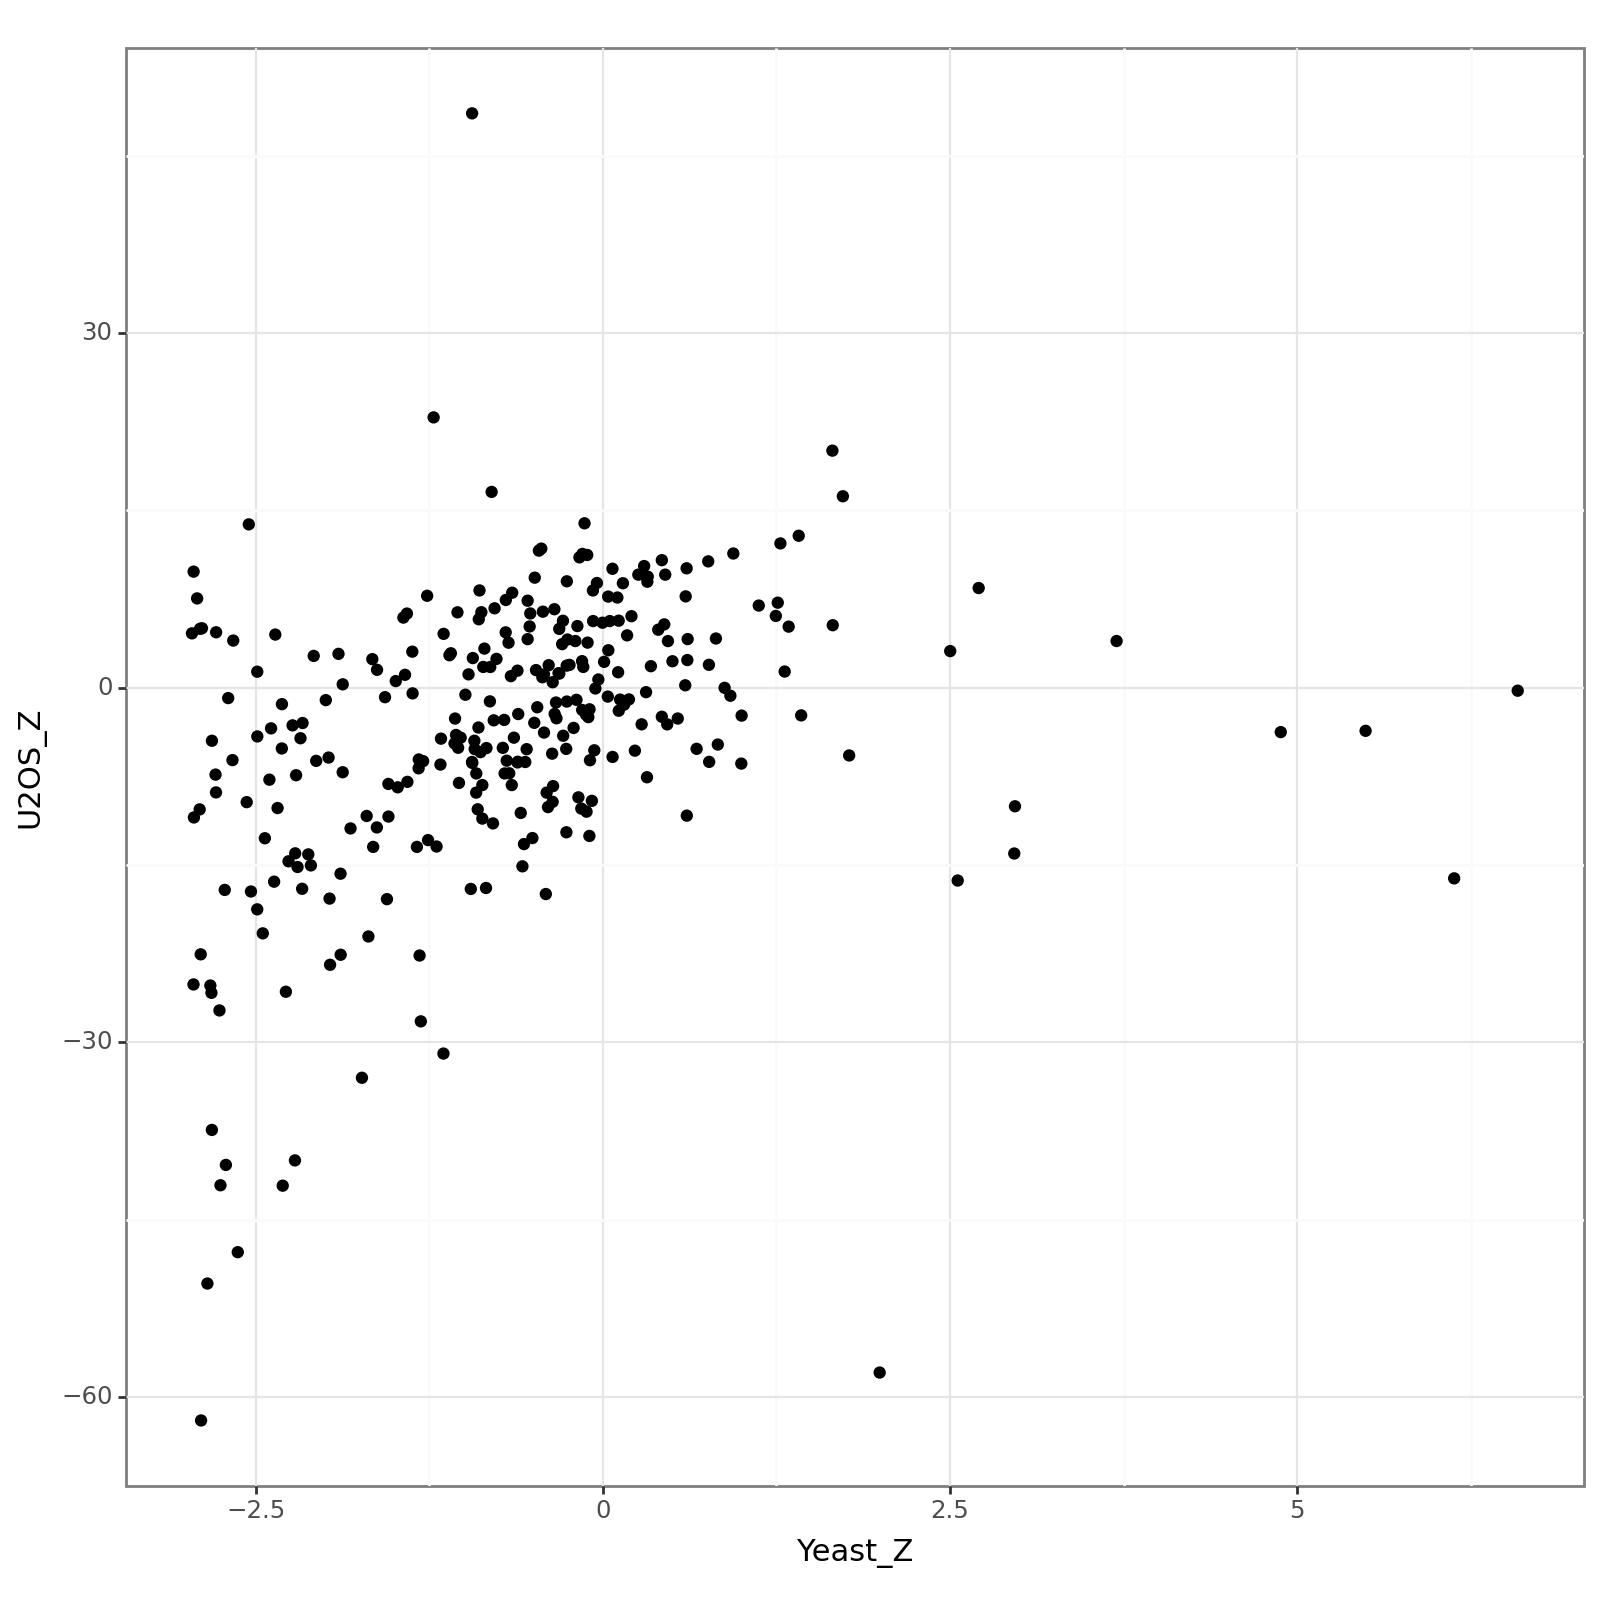

In [98]:
from plotnine import aes, geom_point, ggplot, theme_bw

plotnine.options.figure_size = (8, 8)
plot1 = (
    ggplot(
        abun_both,
        aes(x="Yeast_Z", y="U2OS_Z"),
    )
    + geom_point()
    + theme_bw()
)
print(plot1)

In [101]:
from scipy.stats import pearsonr

u2os_z = abun_both["U2OS_Z"].to_numpy()
yeast_z = abun_both["Yeast_Z"].to_numpy()

corr_coeff, p_value = pearsonr(u2os_z, yeast_z)

print(f"Pearson correlation coefficient: {corr_coeff}")
print(f"P-value: {p_value}")


Pearson correlation coefficient: 0.32056490693417244
P-value: 1.1409530313557542e-08
